In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t import CorticalColumn, LayerConnection, AbstractRewardSystem, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection

In [2]:
# seed = 1303
# random.seed(seed)
# np.random.seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.manual_seed(seed)

In [3]:
input_size = 200
each_session = 30
session_number = 802
layer23_involve_from = 400
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [4]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

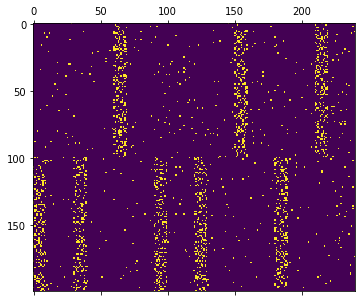

In [5]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [6]:
connection_args = { # Between Layer
    'wmin': 0.,
    'wmax': 1.3,
    'nu': 0.03, # [-, +]
    'probability': 0.3,
    'weight_decay': 0.00000,
    'update_rule': RSTDP_SEASONAL,
    
    'tc_plus': 10,
    'tc_minus': 10, 
    'tc_e_trace': 10,
}
layer_args_l23 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -1.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_rec_con_args': { # Exc -> Exc
        'wmin': 0.,
        'wmax': 0.0,
        'update_rule': NoOp,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 0,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -0.3,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.50,
    },
    'exc_rec_con_args': { # Exc -> Exc
        'wmin': 0.,
        'wmax': 0.0,
        'update_rule': NoOp,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 3,
        'rest':-57
    }
}
connection_type = RandomConnection

In [7]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=10)
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, connection_type, name="c1", monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection(("input_c1", input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 1.0,
    'nu': 0.02,
#     'update_rule': MSTDPET_SEASONAL,
    'update_rule': PostPre,
    'probability': 0.50
})

In [8]:
# class C1Reward(AbstractRewardSystem):
#     def __init__(self):
#         super().__init__()
#         self.set_cortical_column_and_classes(c1, timestep_class)

In [9]:
network = Network(dt=1.0) #, reward_update=True, reward_fn=C1Reward)
network.add_layer(input_pop_c1, "input_c1")
inp_monitor = Monitor(obj=input_pop_c1, state_vars=['s'])

inp_2_c1_monitor_1 = Monitor(obj=input_to_c1_connection.connections[0][2], state_vars=['converge'])
inp_2_c1_monitor_2 = Monitor(obj=input_to_c1_connection.connections[1][2], state_vars=['converge'])
network.add_monitor(monitor=inp_2_c1_monitor_1, name="inp_2_c1_monitor_1")
network.add_monitor(monitor=inp_2_c1_monitor_2, name="inp_2_c1_monitor_2")

bl_monitors = []
bl_monitors_name = []
for a, b, con in c1.l4_l23.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    
network.add_monitor(monitor=inp_monitor, name="input_c1")
c1.add_to_network(network)
input_to_c1_connection.add_to_network(network)

In [10]:
# Disable layer 2,3
c1.l23.disable_learning()
c1.l4_l23.disable_learning()

In [11]:
for x in c1.l4_l23.connections:
    print(x[2].update_rule)

In [12]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

    if part == layer23_involve_from:
        c1.l4.disable_learning()
        input_to_c1_connection.disable_learning()
        
        c1.l23.enable_learning()
        c1.l4_l23.enable_learning()
        
        
    inp = {'input_c1': spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
#     print(exc1_act, exc2_act)
    pattern = session_class[part]
#     gap_check = abs(exc2_act - exc1_act) > 30

    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
#     reward = 1.2 if (exc1_wins == pattern) and gap_check else -1

    if pattern and exc1_act > 40 and exc2_act < 10:
        reward = 1.0 + gap
    elif not pattern and exc2_act > 40 and exc1_act < 10:
        reward = 1.0 + gap
    elif exc1_wins != pattern:
        reward = -1 - gap
    else:
        reward = -0.1
        
#     if exc1_wins != pattern:
#         reward = -1 - gap
#     else:
#         if (exc1_wins == pattern) and gap_check:
#             reward = 1.0 + gap
#         else: # (exc1_wins == pattern) and "NOT" gap_check
#             reward = -0.1
            
    rewards.append(reward)
    
    #TODO Get trigger of connection
    for conn in c1.l4_l23.connections:
#     for conn in c1.l4_l23.connections + input_to_c1_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    
#     c1.pops_reset_state_variables()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 802/802 [01:24<00:00,  9.54parts/s]


In [13]:
rewards[-300:]

[tensor(2.4100),
 tensor(2.6600),
 tensor(-1.8100),
 tensor(1.7900),
 tensor(1.9000),
 tensor(1.9100),
 tensor(2.0100),
 tensor(2.0900),
 tensor(2.0900),
 tensor(2.1900),
 tensor(1.8400),
 tensor(2.3700),
 tensor(2.2800),
 tensor(2.4400),
 tensor(2.2000),
 tensor(1.9500),
 tensor(2.2300),
 -0.1,
 tensor(2.6600),
 tensor(2.7200),
 tensor(1.6500),
 tensor(2.3500),
 tensor(2.4000),
 -0.1,
 tensor(2.5600),
 tensor(2.7400),
 tensor(1.9400),
 tensor(2.0600),
 tensor(2.3300),
 tensor(2.4500),
 tensor(1.8600),
 tensor(2.5000),
 -0.1,
 tensor(2.5700),
 tensor(1.8400),
 tensor(2.1500),
 tensor(2.5400),
 tensor(2.6500),
 tensor(2.1100),
 tensor(2.0900),
 tensor(2.2300),
 tensor(2.3200),
 tensor(2.5400),
 tensor(2.2500),
 -0.1,
 tensor(2.3700),
 tensor(2.5500),
 -0.1,
 tensor(2.6200),
 -0.1,
 tensor(2.4000),
 tensor(2.6700),
 tensor(2.0600),
 tensor(2.5600),
 tensor(2.1600),
 tensor(2.2800),
 -0.1,
 tensor(2.4200),
 tensor(2.7700),
 tensor(2.8100),
 tensor(2.3100),
 tensor(2.7200),
 tensor(2.0600)

In [14]:
session_class[-300:]

tensor([False, False,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True, False,  True,  True, False, False, False,
         True, False, False,  True, False, False,  True,  True, False, False,
         True, False,  True, False,  True,  True,  True,  True, False,  True,
         True, False, False,  True, False, False, False,  True,  True, False,
         True,  True, False, False,  True, False,  True, False, False, False,
         True,  True, False, False,  True,  True, False,  True, False, False,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False, False,  True, False, False, False, False, False,
        False, False, False,  True,  True, False,  True, False,  True, False,
        False, False, False,  True,  True, False, False,  True, False,  True,
        False, False, False, False, False,  True, False, False, False, False,
        False, False,  True, False,  True,  True,  True, False, 

In [15]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('c1_l4__exc1', 'c1_l23__exc1')
('c1_l4__exc1', 'c1_l23__exc2')
('c1_l4__exc2', 'c1_l23__exc1')
('c1_l4__exc2', 'c1_l23__exc2')


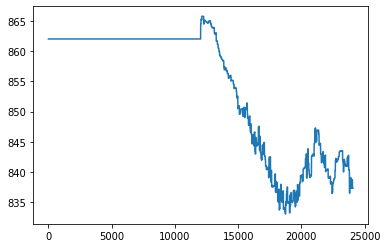

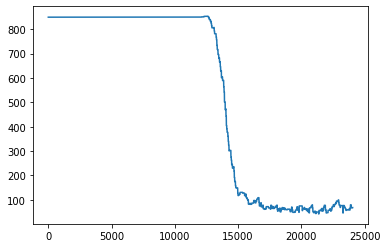

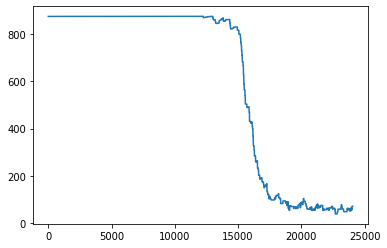

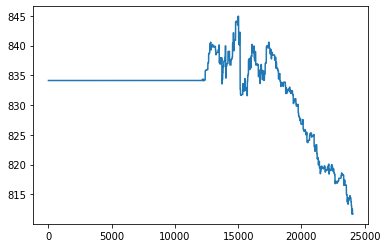

In [16]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

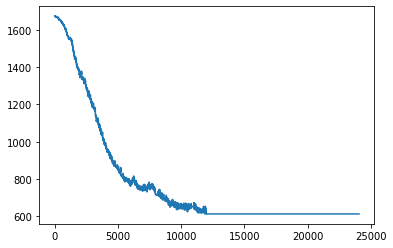

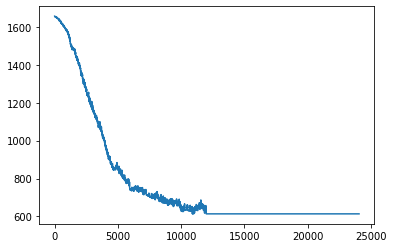

In [17]:
plt.plot(inp_2_c1_monitor_1.get('converge'))
plt.figure()
plt.plot(inp_2_c1_monitor_2.get('converge'))

In [18]:
time_show = time

In [19]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [20]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.6315789222717285
L4 -- Excitatory 1 -- Pattern 2     :    98.25806427001953
L4 -- Excitatory 2 -- Pattern 1     :    97.9473648071289
L4 -- Excitatory 2 -- Pattern 2     :    0.9032257795333862


In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    0.41860464215278625
L4 -- Excitatory 1 -- Pattern 2     :    98.19298553466797
L4 -- Excitatory 2 -- Pattern 1     :    98.06977081298828
L4 -- Excitatory 2 -- Pattern 2     :    0.8421052694320679


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    31.511627197265625
L4 -- Excitatory 1 -- Pattern 2     :    96.1204833984375
L4 -- Excitatory 2 -- Pattern 1     :    94.84496307373047
L4 -- Excitatory 2 -- Pattern 2     :    28.3421688079834


### Layer 2,3

In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    136.73684692382812
L4 -- Excitatory 1 -- Pattern 2     :    2.548387050628662
L4 -- Excitatory 2 -- Pattern 1     :    6.315789699554443
L4 -- Excitatory 2 -- Pattern 2     :    148.64515686035156


In [24]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    135.7441864013672
L23 -- Excitatory 1 -- Pattern 2     :    3.3157894611358643
L23 -- Excitatory 2 -- Pattern 1     :    7.255814075469971
L23 -- Excitatory 2 -- Pattern 2     :    145.84210205078125


In [25]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    91.322998046875
L23 -- Excitatory 1 -- Pattern 2     :    39.807228088378906
L23 -- Excitatory 2 -- Pattern 1     :    18.963825225830078
L23 -- Excitatory 2 -- Pattern 2     :    79.46505737304688


## Pattern Separation

In [26]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c1 (0:99)    --->   c1_l4__exc1   :   342.4327392578125
input_c1 (100:199) --->   c1_l4__exc1   :   514.3013305664062
input_c1 (0:99)    --->   c1_l4__exc2   :   519.3482055664062
input_c1 (100:199) --->   c1_l4__exc2   :   346.7696228027344


In [27]:

for source, target, connection in c1.l4_l23.connections:
    print(f"{source}   --->   {target}   :   {connection.w.sum()}")

c1_l4__exc1   --->   c1_l23__exc1   :   1752.895751953125
c1_l4__exc1   --->   c1_l23__exc2   :   4397.095703125
c1_l4__exc2   --->   c1_l23__exc1   :   3925.337890625
c1_l4__exc2   --->   c1_l23__exc2   :   1953.849365234375


## Activities

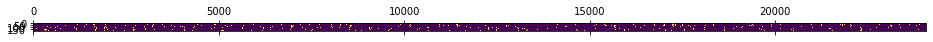

In [28]:
plt.matshow(spike_train.T[:, -time_show:])

In [29]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([24060, 1, 100])

In [30]:
spikes["L4 | 1"].shape

torch.Size([100, 24060])

In [31]:
spikes["L4 | 1"].sum(0).shape[0]

24060

In [32]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [33]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(99)

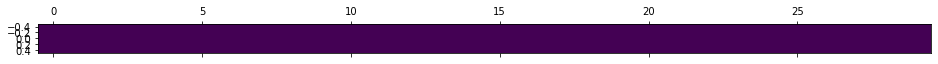

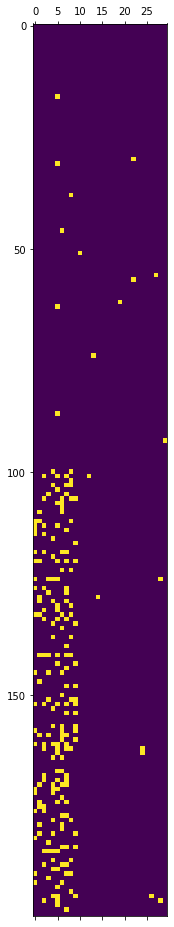

In [34]:
x = 396
plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

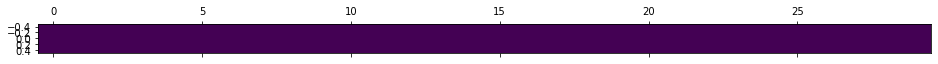

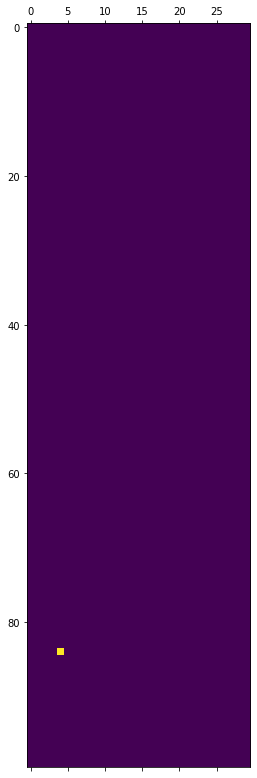

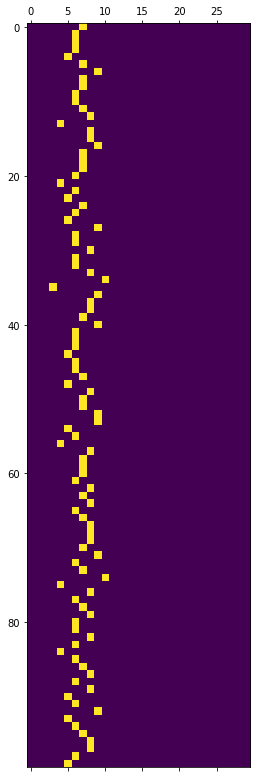

In [35]:
x = 793
plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

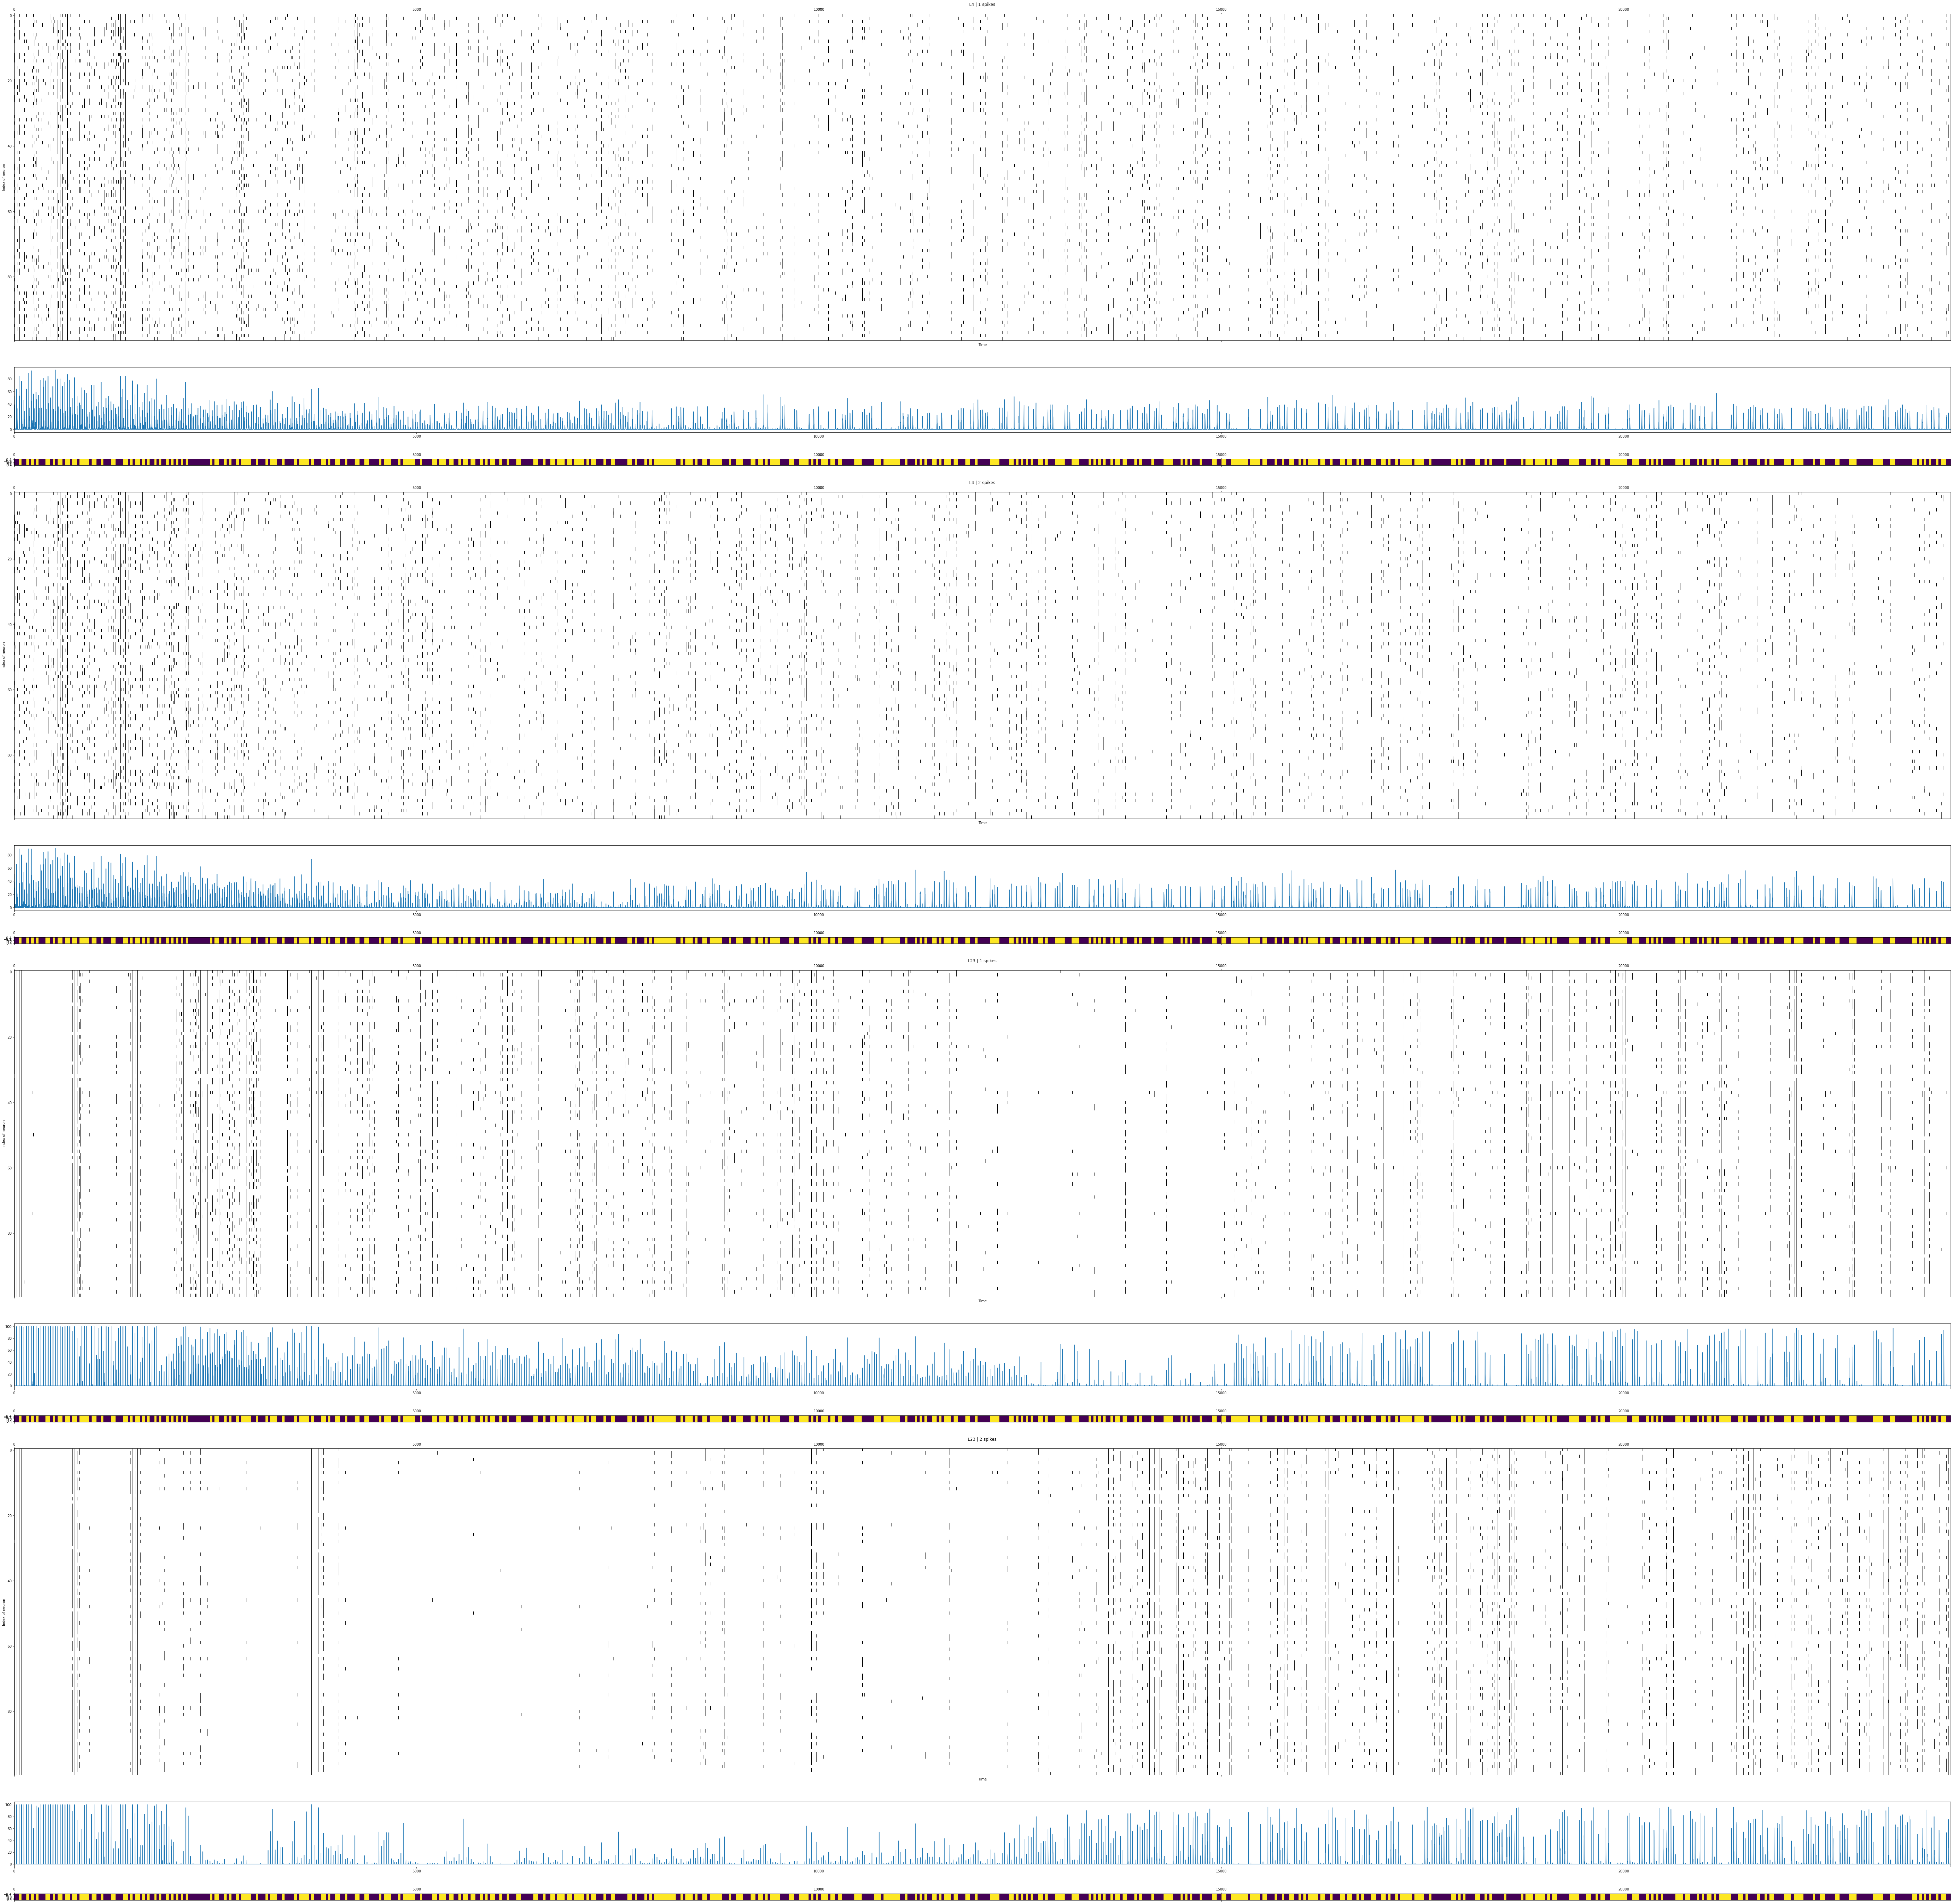

In [36]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

tensor(False)


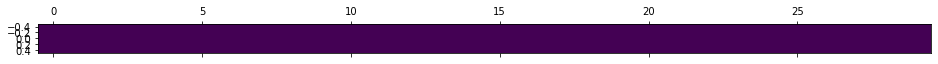

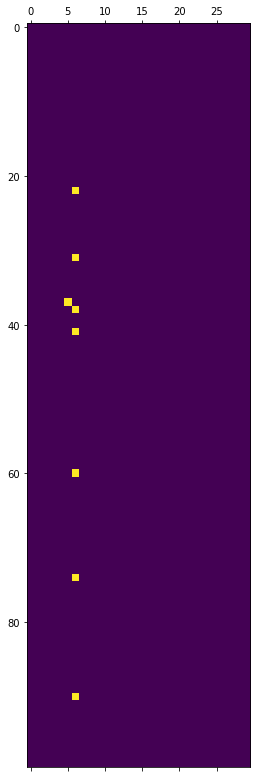

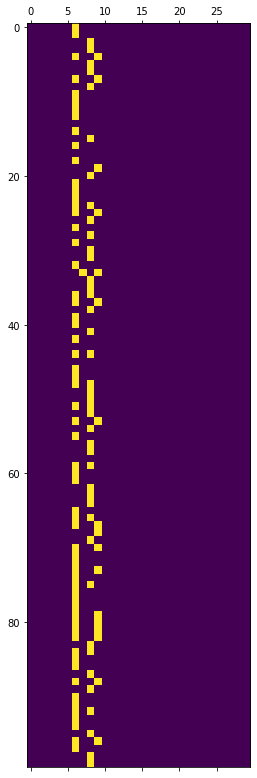

In [37]:
x = 794
print(session_class[x])
plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
plt.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])